# Lab 7: Ensembles learning
## Using trees to detect trees

We will be using tree-based ensemble methods on the [Covertype dataset](https://www.openml.org/d/180).
It contains about 100,000 observations of 7 types of trees (Spruce, Pine, Cottonwood, Aspen,...) described by 55 features describing elevation, distance to water, soil type, etc.

In [ ]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
import seaborn as sns

In [6]:
# Download Covertype data. Takes a while the first time.
covertype = oml.datasets.get_dataset(180)
X, y, _, _ = covertype.get_data(target=covertype.default_target_attribute, dataset_format='array');
classes = covertype.retrieve_class_labels()
features = [f.name for i,f in covertype.features.items()][:-1]

<ipython-input-6-4d1b2603af93>:2: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  covertype = oml.datasets.get_dataset(180)
<ipython-input-6-4d1b2603af93>:3: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, _ = covertype.get_data(target=covertype.default_target_attribute, dataset_format='array');


In [7]:
classes

['Aspen',
 'Cottonwood_Willow',
 'Douglas_fir',
 'Krummholz',
 'Lodgepole_Pine',
 'Ponderosa_Pine',
 'Spruce_Fir']

In [8]:
features[0:20]

['elevation',
 'aspect',
 'slope',
 'horizontal_distance_to_hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points',
 'wilderness_area1',
 'wilderness_area2',
 'wilderness_area3',
 'wilderness_area4',
 'soil_type_1',
 'soil_type_2',
 'soil_type_3',
 'soil_type_4',
 'soil_type_5',
 'soil_type_6']

To understand the data a bit better, we can use a scatter matrix. From this, it looks like elevation is a relevant feature.
Douglas Fir and Aspen grow at low elevations, while only Krummholz pines survive at very high elevations.

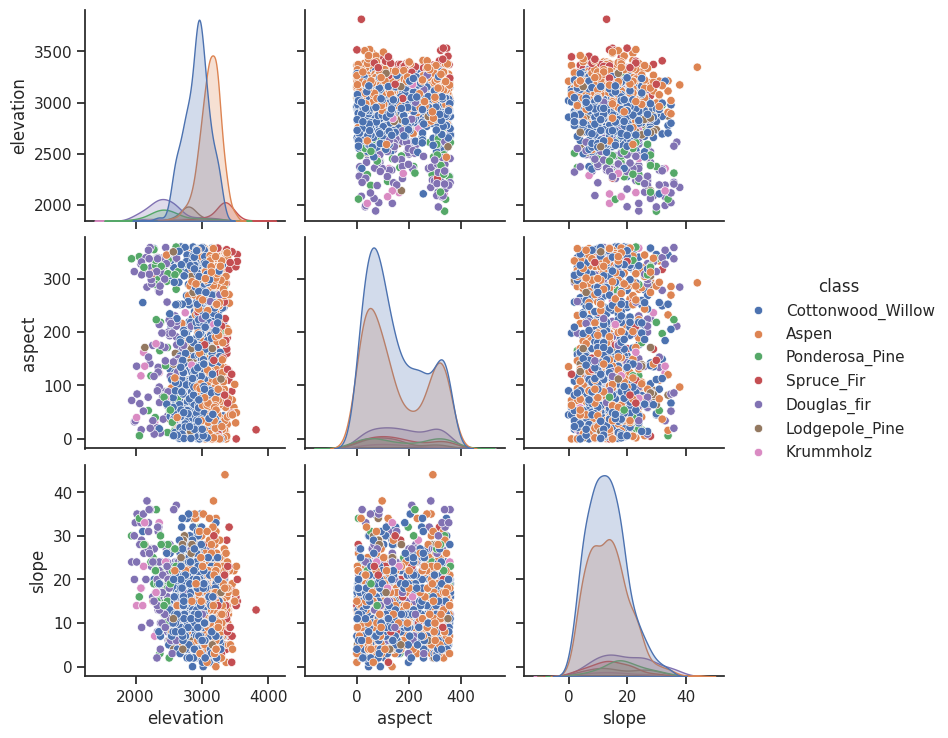

In [9]:
# Using seaborn to build the scatter matrix
# only first 3 columns, first 1000 examples
n_points = 1500
df = pd.DataFrame(X[:n_points,:3], columns=features[:3])
df['class'] = [classes[i] for i in y[:n_points]]
sns.set(style="ticks")
sns.pairplot(df, hue="class");

In [97]:
# Import dependencies
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
import time

# Utils 1
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f", title=None):
    """
    Visualizes the results of a grid search with two hyperparameters as a heatmap.
    Attributes:
    values -- The test scores
    xlabel -- The name of hyperparameter 1
    ylabel -- The name of hyperparameter 2
    xticklabels -- The values of hyperparameter 1
    yticklabels -- The values of hyperparameter 2
    cmap -- The matplotlib color map
    vmin -- the minimum value
    vmax -- the maximum value
    ax -- The figure axes to plot on
    fmt -- formatting of the score values
    """
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)
    ax.set_title(xlabel + " vs " + ylabel if title == None else title)

    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=90)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center", size=10)
    return img

# Utils 2
def accuracy_plot(mean_test_score, max_depth, n_estimators, param1_label="max_depth", size=(18, 6)):
  plt.figure(figsize=size)
  for row in range(mean_test_score.shape[0]):
    plt.plot(n_estimators, mean_test_score[row,:], label=f"{param1_label}_{max_depth[row]}")
  plt.xlabel("n_estimators")
  plt.ylabel("mean_test_score accuracy")
  plt.title('Model accuracy for different hyperparameters')
  plt.legend()
  plt.show()

# Utils 3
def accuracy_heat_map(mean_test_score, xlabels, ylabels, title, param1_label="max_depth", size=(15, 6)):
  plt.figure(figsize=size)
  heatmap(mean_test_score, xlabel="n_estimators", ylabel=param1_label, xticklabels=xlabels, yticklabels=ylabels, cmap=None, vmin=None, vmax=None, ax=None, fmt="%0.2f", title=title)
  plt.tight_layout()

## Exercise 1: Random Forests
Implement a function `evaluate_RF` that measures the performance of a Random Forest Classifier, using trees
of (max) depth 2,8,32,64, for any number of trees in the ensemble (`n_estimators`).
For the evaluation you should measure accuracy using 3-fold cross-validation.
Use `random_state=1` to ensure reproducibility. Finally, plot the results for at least 5 values of `n_estimators` ranging from 1 to 30. You can, of course, reuse code from earlier labs and assignments. Interpret the results.
You can take a 50% subsample to speed the plotting.

In [11]:
# Let take 50% subsample of initial data
X_reduced, _, y_reduced, _ = train_test_split(X,y, stratify=y, random_state=1, train_size=0.5)

In [78]:
def evaluate_RF(max_depth, n_estimators, X=X_reduced, y=y_reduced, timeit=False, scoring=None, title=None):
  start_time = time.time()
  model       = RandomForestClassifier(random_state=1)
  parameters  = {'n_estimators': n_estimators, 'max_depth': max_depth}
  grid_search = GridSearchCV(model, parameters, cv=StratifiedKFold(n_splits=3), n_jobs=-1, scoring=scoring);
  grid_search.fit(X, y);
  elapsed_time = time.time() - start_time
  if timeit:
    print(f"Elapsed time: {elapsed_time:.3f} seconds")

  # score
  mean_test_score = grid_search.cv_results_['mean_test_score']
  mean_test_score = mean_test_score.reshape(len(max_depth), len(n_estimators))
  xlabels = np.round(parameters['n_estimators'], 2)
  ylabels = np.round(parameters['max_depth'], 2)

  return mean_test_score, xlabels, ylabels

In [82]:
max_depth    = [2, 8, 32, 64]
n_estimators = [i for i in range(1, 31)]
mean_test_score, xlabels, ylabels = evaluate_RF(max_depth, n_estimators)

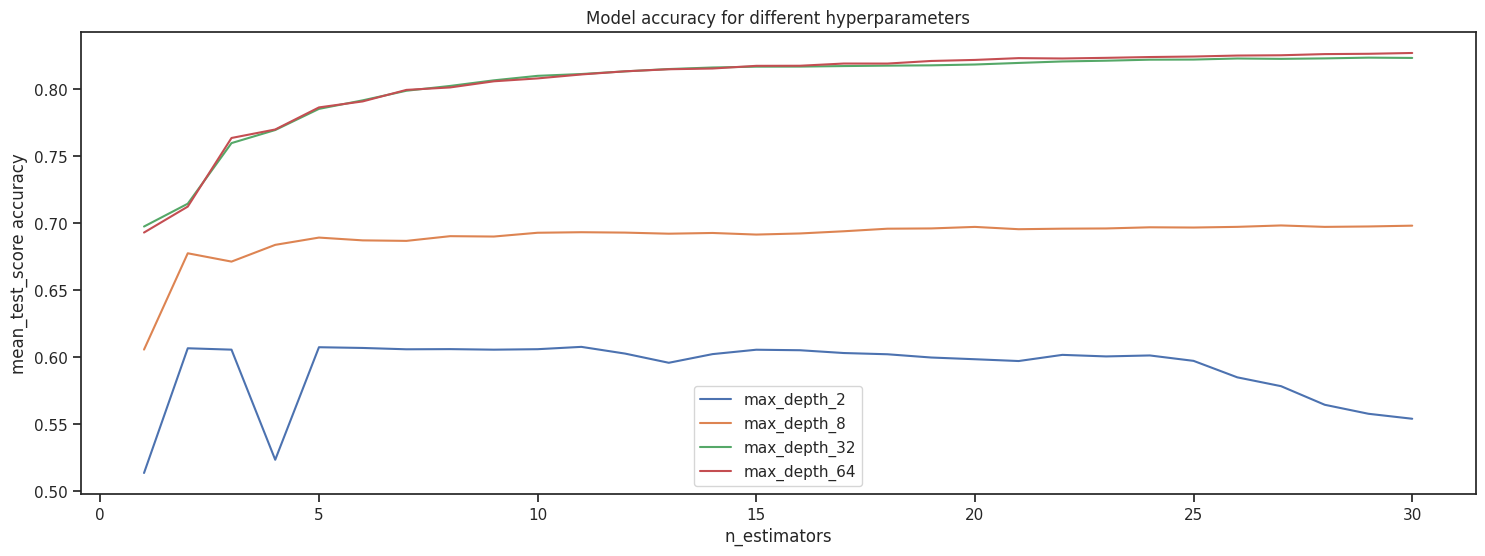

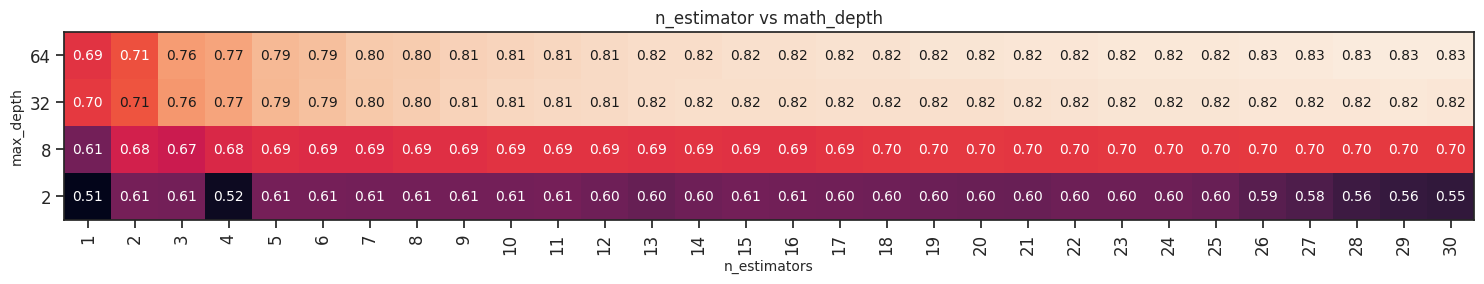

In [83]:
accuracy_plot(mean_test_score, max_depth, n_estimators)
accuracy_heat_map(mean_test_score, xlabels, ylabels, "n_estimator vs math_depth")

**Interpretation**
> We observe that the higher the maximum depth of the tree and the greater the number of estimators, the higher the precision obtained. Thus, trees with depths of 2, 8, 32, and 64 achieve maximum precisions of 0.55, 0.70, 0.82, and 0.83 respectively as the number of estimators increases. Therefore, the deeper the tree and the more estimators there are, the more precise the model is.<br>
However, we notice that from a depth of 32 to 64, there is not enough difference in terms of performance obtained except when n_estimators exceeds 26. Then the optimal max_depth=32.

## Exercise 2: Other measures
Repeat the same plot but now use balanced_accuracy as the evaluation measure. See the [documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score).
Only use the optimal max_depth from the previous question. Do you see an important difference?

In [57]:
df = pd.DataFrame()
df['class']   = [classes[i] for i in y_reduced]
classe_counts = df['class'].value_counts()
proportion_classes = classe_counts / len(df)
print("\nProportion of each class :")
print(proportion_classes)


Proportion of each class :
Cottonwood_Willow    0.468168
Aspen                0.352435
Douglas_fir          0.066798
Spruce_Fir           0.040836
Ponderosa_Pine       0.035945
Lodgepole_Pine       0.023679
Krummholz            0.012139
Name: class, dtype: float64


These values show us that we are dealing with an unbalancing dataset

In [60]:
max_depth    = [32]
n_estimators = [i for i in range(1, 31)]
mean_test_score, xlabels, ylabels = evaluate_RF(max_depth, n_estimators, scoring="balanced_accuracy")

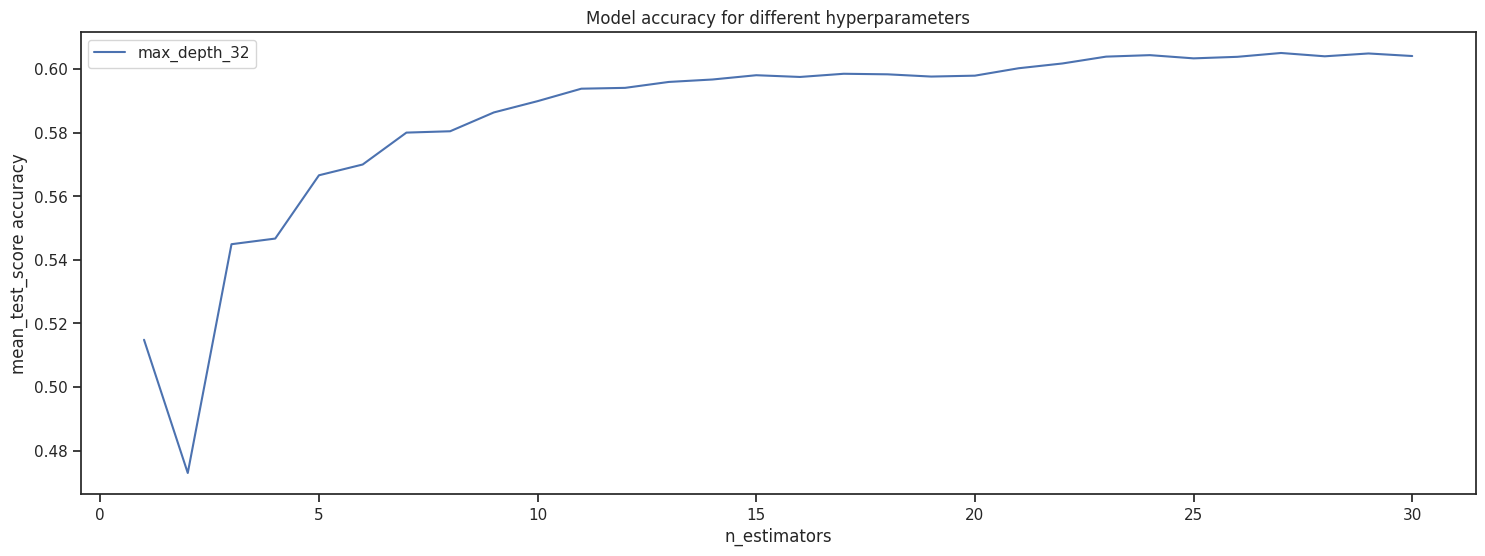

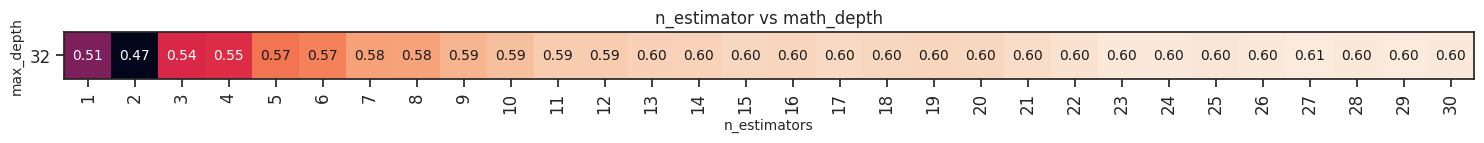

In [62]:
accuracy_plot(mean_test_score, max_depth, n_estimators)
accuracy_heat_map(mean_test_score, xlabels, ylabels, "n_estimator vs math_depth")

**Interpretation**
> For the chosen max_depth, we observe that the more estimators we have, the more precise the model becomes. However, the model performs worse than the previous one when we used 'balanced_accuracy' as the scoring metric. In fact, the maximum accuracy is around 61% compared to the 82% previously obtained. (the tuned model paraters are **n_estimator=27 and max_depth=32**)<br>
Since we are dealing with an unbalanced dataset, using this scoring metric reveals the true measure of our model's performance.

## Exercise 3: Feature importance
Retrieve the feature importances according to the (tuned) random forest model. Which feature are most important?

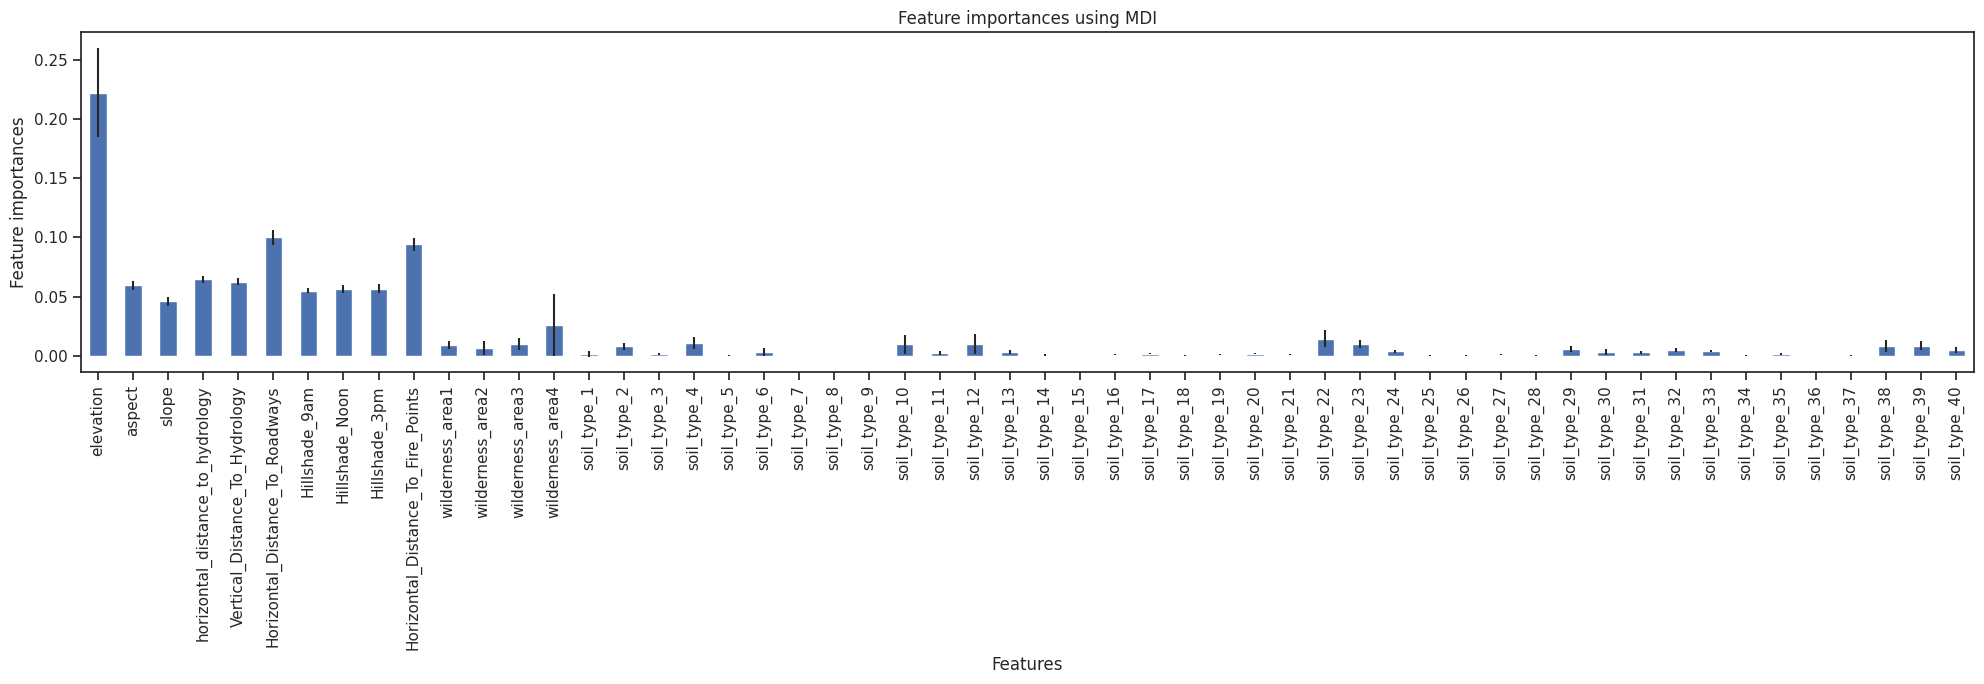

In [64]:
# BEST MODEL
model = RandomForestClassifier(n_estimators=27, max_depth=32, random_state=1)
model.fit(X_reduced, y_reduced)
importances = model.feature_importances_
forest_importances = pd.Series(importances, index=features)
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(20, 7))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Features")
ax.set_ylabel("Feature importances")
fig.tight_layout()

**Interpretation**
> Regarding the image we can say that the top 10 most important feature are: '**elevation**', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'horizontal_distance_to_hydrology',  'Vertical_Distance_To_Hydrology','aspect', 'slope'.

## Exercise 4: Feature selection
Re-build your tuned random forest, but this time only using the first 10 features.
Return both the balanced accuracy and training time. Interpret the results.

In [79]:
max_depth    = [32]
n_estimators = [27]
mean_test_score, _, _ = evaluate_RF(max_depth, n_estimators, X=X_reduced, y=y_reduced, timeit=True, scoring="balanced_accuracy")
print("Banlanced_Accuracy : ", mean_test_score[0][0])

Elapsed time: 11.190 seconds
Banlanced_Accuracy :  0.6050512697960893


In [80]:
max_depth    = [32]
n_estimators = [27]
mean_test_score, _, _ = evaluate_RF(max_depth, n_estimators, X=X_reduced[:,:10], y=y_reduced, timeit=True, scoring="balanced_accuracy")
print("Banlanced_Accuracy : ", mean_test_score[0][0])

Elapsed time: 13.632 seconds
Banlanced_Accuracy :  0.5753792639539871


**Interpretation**
> We observe that by focusing on the important features, we achieve a precision of 0.58 compared to 0.60 when using all features. Additionally, despite reducing the number of features, the time required for training the model increase very slightly by 3 up to 4 seconds.<br>
As a result, it is not necessary to proceed with features reduction.

## Exercise 5: Confusion matrix
Do a standard stratified holdout and generate the confusion matrix of the tuned random forest. Which classes are still often confused?

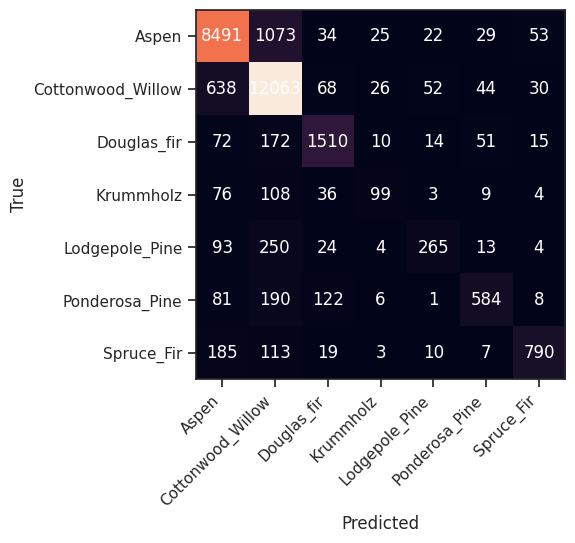

In [81]:
# Standard stratified holdout
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# Train tuned random forest
model = RandomForestClassifier(n_estimators=27, max_depth=32, random_state=1)
model.fit(X_train, y_train)

# Prediction and confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()
im = ax.imshow(cm)
n_classes = len(classes)
ax.set_xticks(np.arange(n_classes))
ax.set_yticks(np.arange(n_classes))
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.set_yticklabels(classes)
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
for i in range(n_classes**2):
    ax.text(int(i/n_classes),i%n_classes,cm[i%n_classes,int(i/n_classes)], ha="center", va="center", color="w")

**Interpretation**
> When we carefully observe this confusion matrix, we see that almost all tree classes are often confused. However, this confusion is particularly high for classes such as "Aspen," "Cottonwood_willow," and "Douglas_fir", "Krummholz" and "Lodgepole_Pine"

## Exercise 6: A second-level model
Build a binary model specifically to correctly choose between the first and the second class.
Select only the data points with those classes and train a new random forest. Do a standard stratified split and plot the resulting ROC curve. Can we still improve the model by calibrating the threshold?

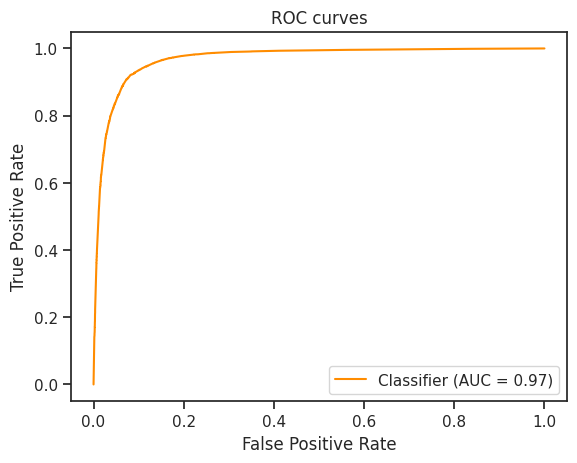

In [84]:
# Let select class 0 and 1 only
X_bin = X[y<2, :]
y_bin = y[y<2]

# Standard stratified holdout
X_train, X_test, y_train, y_test = train_test_split(X_bin, y_bin, stratify=y_bin)

# Train and predict
model_bin = RandomForestClassifier(n_estimators=27, max_depth=32, random_state=1)
model_bin.fit(X_train, y_train)
y_pred_proba = model_bin.predict_proba(X_test)

# ROC Curve
display = RocCurveDisplay.from_predictions(
    y_test,
    y_pred_proba[:,1],
    color="darkorange",
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curves",
)

In [85]:
# Find the best threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1], pos_label=1)
best_threshold_index = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_index]
print("Best Threshold: ", best_threshold)

Best Threshold:  0.5925925925925926


**Interpretation**
> Here our positive class is 1. We can tune the threshold to minimize the number of false positives and maximize the true positives. Therefore, we can try the value 0.60 for the threshold as computed in the cell above.

## Exercise 7: Model calibration
For the trained binary random forest model, plot a calibration curve (see [course notebook](https://ml-course.github.io/engineer/slides_html/03%20-%20Model%20Selection.slides.html#/40)).
Next, try to correct for this using Platt Scaling (or sigmoid scaling).

Probability calibration should be done on new data not used for model fitting. The class [CalibratedClassifierCV](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py) uses a cross-validation generator and estimates for each split the model parameter on the train samples and the calibration of the test samples. The probabilities predicted for the folds are then averaged. Already fitted classifiers can be calibrated by CalibratedClassifierCV via the parameter cv=”prefit”. [Read more](https://scikit-learn.org/stable/modules/calibration.html)

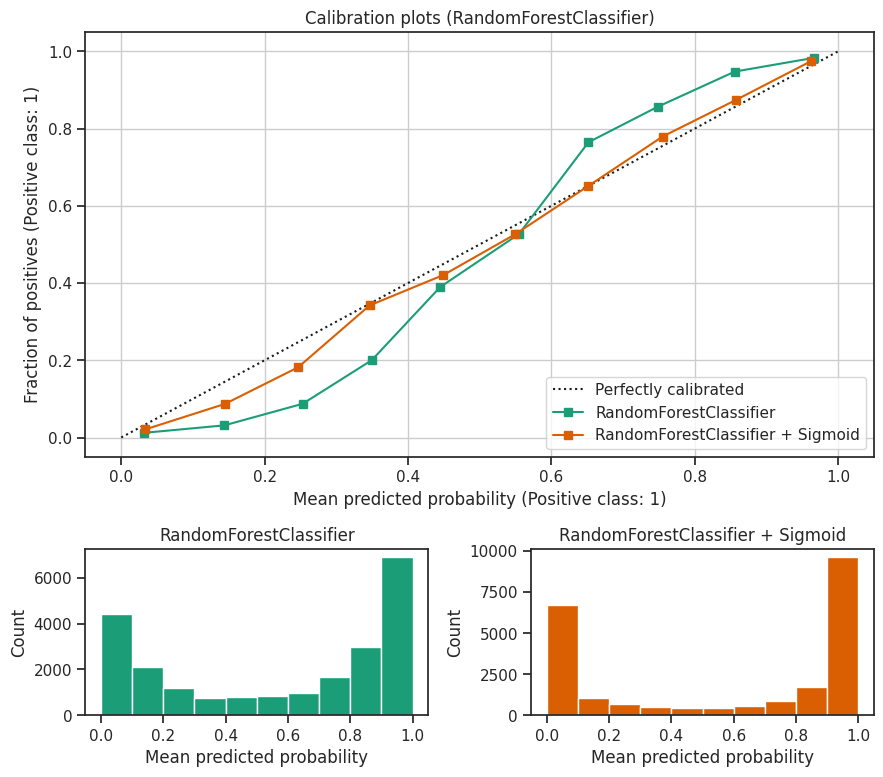

In [89]:
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.calibration import calibration_curve
from matplotlib.gridspec import GridSpec

model_bin_sigmoid = CalibratedClassifierCV(model_bin, cv=5, method="sigmoid")
clf_list = [
    (model_bin, "RandomForestClassifier"),
    (model_bin_sigmoid, "RandomForestClassifier + Sigmoid"),
]

# Plot
fig = plt.figure(figsize=(9, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (RandomForestClassifier)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

**Interpretation**
> In this section where we perform model calibration using the sigmoid function, we observe that after calibration, we obtain a calibration curve that approaches perfection compared to the uncalibrated model curve. The new probabilities obtained with this calibrated model will be much more precise.

## Exercise 8: Gradient Boosting
Implement a function `evaluate_GB` that measures the performance of `GradientBoostingClassifier` or the `XGBoostClassifier` for
different learning rates (0.01, 0.1, 1, and 10). As before, use a 3-fold cross-validation. You can use a 5% stratified sample of the whole dataset.
Finally plot the results for `n_estimators` ranging from 1 to 100. Run all the GBClassifiers with `random_state=1` to ensure reproducibility.

In [90]:
from sklearn.ensemble import GradientBoostingClassifier

def evaluate_GB(learning_rates, n_estimators, X, y, scoring=None, title=None):
  model       = GradientBoostingClassifier(random_state=1)
  parameters  = {'n_estimators': n_estimators, 'learning_rate': learning_rates}
  grid_search = GridSearchCV(model, parameters, cv=StratifiedKFold(n_splits=3), n_jobs=-1, scoring=scoring);
  grid_search.fit(X_reduced, y_reduced);

  mean_test_score = grid_search.cv_results_['mean_test_score']
  mean_test_score = mean_test_score.reshape(len(learning_rates), len(n_estimators))
  xlabels = np.round(parameters['n_estimators'], 3)
  ylabels = np.round(parameters['learning_rate'], 3)

  return mean_test_score, xlabels, ylabels

Implement a function that plots the score of `evaluate_GB` for `n_estimators` = 10,20,30,...,100 on a linear scale.

In [91]:
# Let's reduce data
X_reduced, _, y_reduced, _ = train_test_split(X, y, stratify=y, train_size=0.05)

# Let's tune the model
learning_rates = [0.01, 0.1, 1, 10]
n_estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
mean_test_score, xlabels, ylabels = evaluate_GB(learning_rates, n_estimators, X=X_reduced, y=y_reduced, scoring="balanced_accuracy", title="GradientBoostingClassifier params tuned heatmap")

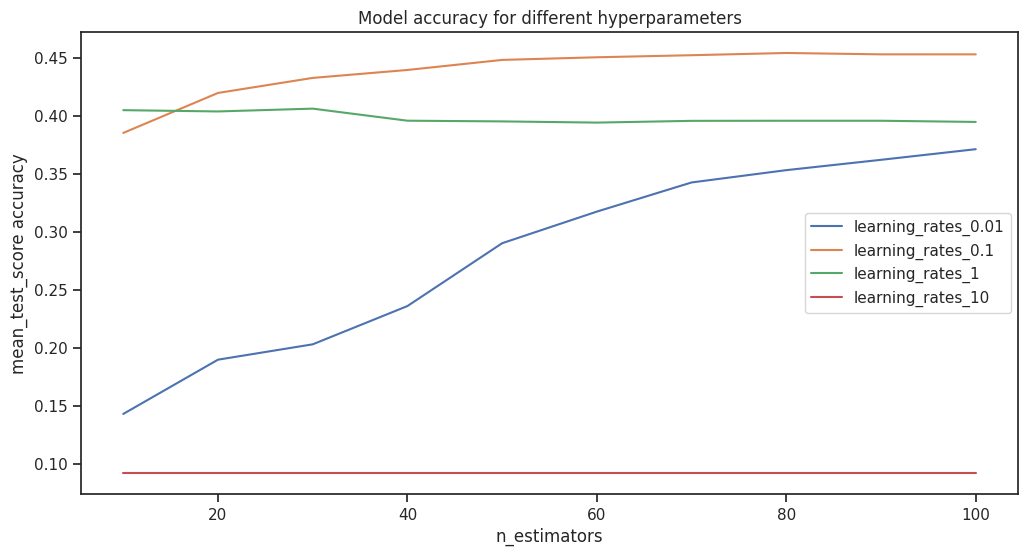

In [115]:
accuracy_plot(mean_test_score, learning_rates, n_estimators, param1_label="learning_rates",  size=(12.1, 6))

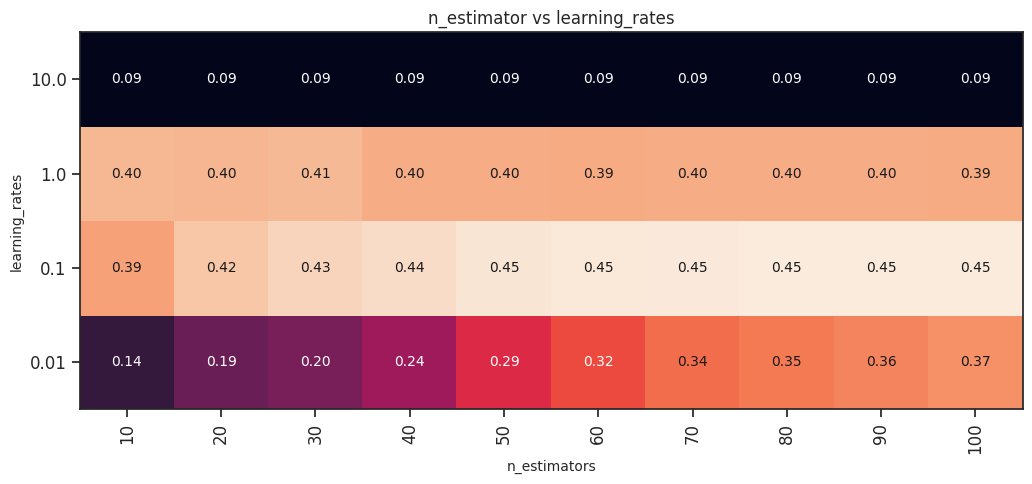

In [116]:
accuracy_heat_map(mean_test_score, xlabels, ylabels, "n_estimator vs learning_rates", param1_label="learning_rates", size=(13, 5))

**Interpretation**
> - Learning rate too large<br>
Models with a learning rate that is too large have a performance that remains static and does not improve much. For the case of learning_rate=10, this model does not generalize at all. As for learning_rate=1, it has a precision of 0.4, which is below 50%.
> - Learning rate too small<br>
For the case of learning_rate=0.01, we observe that as we increase the number of estimators, the precision gradually increases, reaching its maximum peak of 0.37.
> - Learning rate 0.1
For this learning rate, we notice that the precision increases over time and reaches the highest performance with a precision of 0.45. The optimal tuned model is obtained for learning_rate=0.1 and n_estimators=50.

Note: The choice of learning rate and other parameters is crucial. Also, different precisions can be obtained depending on the chosen model.

In [112]:
# END LAB - GENEREUX AKOTENOU